In [0]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *


Size of image used

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
imgSize = 256

# Load Data

In [0]:
x_train = np.load("/content/drive/My Drive/Colab Notebooks/trainx.npy")
y_train = np.load("/content/drive/My Drive/Colab Notebooks/trainy.npy")

In [5]:
print(x_train.shape)
print(y_train.shape)

(2318, 512, 512, 3)
(2318,)


# Resize Image

In [6]:
x_train_new = np.zeros(shape=(2318, imgSize, imgSize, 3))  # Array with all images
scale_percent = 50 # percent of original size
width = imgSize
height = imgSize
dim = (width, height)

img=x_train[0]
resized = cv2.resize(img, dim , interpolation = cv2.INTER_AREA)
for i in tqdm(range(2318)):
    img=x_train[i]
    x_train_new[i]= cv2.resize(img, dim , interpolation = cv2.INTER_AREA)

del(x_train)


100%|██████████| 2318/2318 [00:01<00:00, 1723.58it/s]


In [7]:
print(x_train_new.shape)
print(y_train.shape)

Y=y_train
del(y_train)
X=x_train_new
del(x_train_new)

print(X.shape)
print(Y.shape)

(2318, 256, 256, 3)
(2318,)
(2318, 256, 256, 3)
(2318,)


Categorize Y

In [0]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y)

In [9]:
print(X.shape)
print(Y.shape)

(2318, 256, 256, 3)
(2318, 3)


# Splitting the Input 

In [0]:
(trainX, ValidX, trainY, ValidY) = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [11]:
del X
del Y
# del trainX
# del testX
# del ValidX
print(trainY.shape)
print(trainX.shape)
# ntimes = 6
# trainY = trainY.tolist()
# print(len(trainX))

(1854, 3)
(1854, 256, 256, 3)


In [0]:
trainX = np.array(trainX).astype('float16')/255
ValidX = np.array(ValidX).astype('float16')/255
# testX = np.array(testX).astype('float16')/255

# Augumentation

In [0]:
trainAug = ImageDataGenerator(rotation_range=20, horizontal_flip = True,fill_mode="nearest")
# validAug = ImageDataGenerator()

# validation_generator = test_datagen.flow_from_directory('data/validation',target_size=(150, 150),batch_size=32,class_mode='binary')


In [14]:
print(len(ValidY))
print(len(ValidX))
print(len(trainX))
print(len(trainY))


464
464
1854
1854


# Save Best Model

In [0]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('model_Vgg_vis.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('model_Vgg_vis.h5')

# MODEL Arch

In [0]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

# Train model

In [17]:
INIT_LR = 3e-4
EPOCHS = 40
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(ValidX, ValidY),
    validation_steps=len(ValidX) // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
#              EarlyStopping(monitor='val_accuracy', patience=3),
#              ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=2),
              ],
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
57/57 [==============================] - 47s 826ms/step - loss: 0.6406 - accuracy: 0.7552 - val_loss: 0.3139 - val_accuracy: 0.8599
Epoch 2/40
57/57 [==============================] - 38s 674ms/step - loss: 0.3928 - accuracy: 0.8551 - val_loss: 0.2713 - val_accuracy: 0.8793
Epoch 3/40
57/57 [==============================] - 39s 680ms/step - loss: 0.3361 - accuracy: 0.8672 - val_loss: 0.2413 - val_accuracy: 0.8966
Epoch 4/40
57/57 [==============================] - 39s 682ms/step - loss: 0.2800 - accuracy: 0.9023 - val_loss: 0.1855 - val_accuracy: 0.9267
Epoch 5/40
57/57 [==============================] - 39s 678ms/step - loss: 0.2636 - accuracy: 0.9029 - val_loss: 0.1724 - val_accuracy: 0.9375
Epoch 6/40
57/57 [==============================] - 38s 669ms/step - loss: 0.2655 - accuracy: 0.8963 - val_loss: 0.1762 - val_accuracy: 0.9418
Epoch 7/40
57/57 [==============================] - 39s 677ms/step

Model History

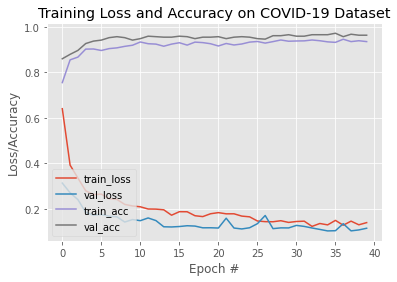

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Load best model

In [0]:
model= load_model('model_Vgg_vis.h5')

In [0]:
model.save('/content/drive/My Drive/model_Vgg_vis.h5')


# Result 

In [24]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [0]:
print(le.classes_)

[0 1 2]


Accuracy and details on Validation

In [0]:
predIdxs_valid = model.predict(ValidX, batch_size=32)
predIdxs_valid = np.argmax(predIdxs_valid, axis=1)
# predIdxs_valid= predIdxs_valid.tolist()


In [32]:
print(predIdxs_valid)

[1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 0 1 1 1 1 1 1 2 1 2 2 2 1 2 1 2 2 2 0 1 1 2
 2 0 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 1 1 0 2 1 2 2 0 1 2 2 1 2 2
 2 1 1 0 2 0 1 1 1 1 2 1 2 1 1 1 1 2 2 2 2 2 1 1 2 1 2 1 1 2 2 2 0 2 2 2 2
 2 1 0 1 1 1 2 2 2 1 1 2 1 2 1 2 1 2 2 2 0 1 1 2 2 1 1 1 2 2 1 1 1 1 1 0 1
 1 1 2 2 2 2 2 2 1 0 0 2 2 2 1 2 0 2 2 1 2 1 2 2 2 1 1 1 2 2 2 2 1 1 1 1 2
 2 1 2 2 2 1 2 1 1 1 2 2 2 2 2 1 1 1 2 2 1 1 0 1 1 0 1 2 1 1 0 1 2 1 2 1 1
 2 1 1 2 2 1 1 0 2 1 1 2 1 1 2 1 2 2 0 2 1 2 2 2 0 2 1 1 1 2 1 1 0 1 2 2 2
 2 2 1 2 2 1 2 1 1 2 0 2 2 1 0 1 1 1 2 2 1 2 1 2 2 0 2 1 2 1 1 2 2 1 0 2 1
 2 2 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 1 2 1 1 2 2 1 1 1 1 1 2 0 2 2
 1 1 1 1 2 1 2 2 1 1 1 2 1 1 2 1 2 0 2 1 2 2 1 1 2 2 1 2 1 2 2 1 1 2 2 1 1
 1 2 1 1 2 1 2 2 2 2 2 2 0 2 2 0 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 0 1 2 0 2 1
 2 2 2 2 2 1 2 2 2 1 2 1 2 2 1 1 1 2 1 2 2 1 2 2 2 0 1 2 2 2 1 1 2 0 1 1 2
 0 2 0 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 2]


In [27]:
# ValidY needs to be updated to a list
print(ValidY)
print(predIdxs_valid)
ValidY_list= predIdxs_valid
for i in range(len(predIdxs_valid)):
  if ValidY[i][0]==1:
    ValidY_list[i]=0
  elif ValidY[i][1]==1:
    ValidY_list[i]=1
  elif ValidY[i][2]==1:
    ValidY_list[i]=2

print(ValidY_list)


[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 0 1 1 1 1 1 1 2 1 2 2 2 1 2 1 2 2 2 0 1 1 2
 2 0 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 1 1 0 2 1 2 2 0 1 2 2 1 2 2
 2 1 1 0 2 0 1 1 1 1 2 1 2 1 1 1 1 2 2 2 2 2 1 1 2 1 2 1 1 2 2 2 0 2 2 2 2
 2 1 0 1 1 1 2 2 2 1 1 2 1 2 1 2 1 2 2 2 0 1 1 2 2 1 1 1 2 2 1 1 1 1 1 0 1
 1 1 2 2 2 2 2 2 1 0 0 2 2 2 1 2 0 2 2 1 2 1 2 2 2 1 1 1 2 2 2 2 1 1 1 1 2
 2 1 2 2 2 1 2 1 1 1 2 2 2 2 2 1 1 1 2 2 1 1 0 1 1 0 1 2 1 1 0 1 2 1 2 1 1
 2 1 1 2 2 1 1 0 2 1 1 2 1 1 2 1 2 2 0 2 1 2 2 2 0 2 1 1 1 2 1 1 0 1 2 2 2
 2 2 1 2 2 1 2 1 1 2 0 2 2 1 0 1 1 1 2 2 1 2 1 2 2 0 2 1 2 1 1 2 2 1 0 2 1
 2 2 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 1 2 1 1 2 2 1 1 1 1 1 2 0 2 2
 1 1 1 1 2 1 2 2 1 1 1 2 1 1 2 1 2 0 2 1 2 2 1 1 2 2 1 2 1 2 2 1 1 2 2 1 1
 1 2 1 1 2 1 2 2 2 2 2 2 0 2 2 0 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 0 1 2 0 2 1
 2 2 2 2 2 1 2 2 2 1 2 1 2 2 1 1 1 2 1 2 2 1 2 2 2 0 1 2 2 2 1 1 2 0 1 1 2
 0 2 0 1 1 1 1 1 1 1 1

In [33]:
print(classification_report(ValidY_list, predIdxs_valid,  digits = 5))

              precision    recall  f1-score   support

           0    0.94286   0.97059   0.95652        34
           1    0.97642   0.96279   0.96956       215
           2    0.97235   0.98140   0.97685       215

    accuracy                        0.97198       464
   macro avg    0.96387   0.97159   0.96764       464
weighted avg    0.97207   0.97198   0.97198       464



Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(ValidY_list,predIdxs_valid )
# report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(matrix)    


[[ 33   1   0]
 [  2 207   6]
 [  0   4 211]]


In [0]:
# from sklearn.metrics import multilabel_confusion_matrix

# mcm= multilabel_confusion_matrix(testY_temp, predIdxs)

ROC Curve

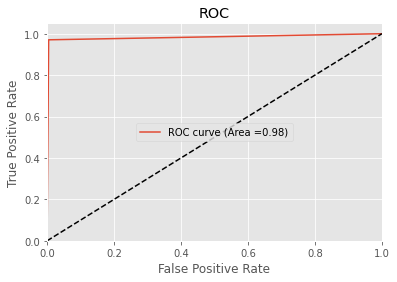

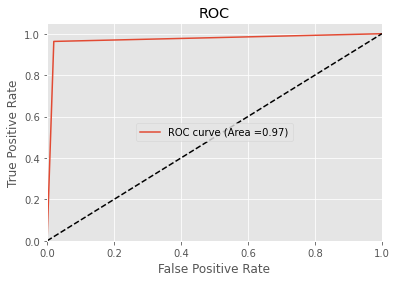

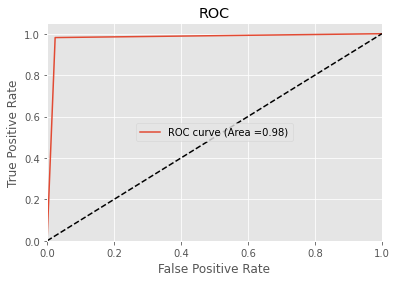

{0: 0.98296853625171, 1: 0.9713551881946391, 2: 0.9786494816475203}


In [35]:
#ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline

y_test= label_binarize(ValidY_list,classes=[0,1,2])
y_pred= label_binarize(predIdxs_valid,classes=[0,1,2])

fpr = dict()
tpr = dict()
n_classes=3
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


    
for i in range(3):
    plt.figure()
    plt.plot(fpr[i],tpr[i],label='ROC curve (Area =%0.2f)' %roc_auc[i])
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="center")
    

plt.show()
   
print(roc_auc)

# GradCAM Visualisation

In [36]:
!pip install tf-keras-vis tensorflow

import tensorflow as tf
# from tf_keras_vis.utils import print_gpus

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras import backend as K
# from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# # Create Saliency object
# saliency = Saliency(model, model_modifier, clone=False)

# # Generate saliency map
# saliency_map = saliency(loss, X)
# saliency_map = normalize(saliency_map)

# f, ax = plt.subplots(**subprot_args)
# for i in range(len(saliency_map)):
#     ax[i].imshow(saliency_map[i], cmap='jet')
# plt.tight_layout()
# plt.show()



float16


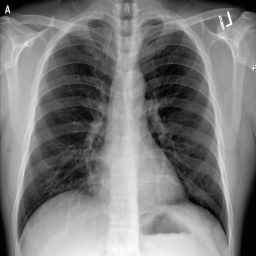

[1. 0. 0.]
<class 'numpy.ndarray'> (256, 256, 3)


In [53]:
import keras
img_test= trainX[1]
print(img_test.dtype)
display(keras.preprocessing.image.array_to_img(img_test))
print(trainY[1])
print(type(img_test), img_test.shape)


In [46]:
img_test = np.expand_dims(img_test, axis=0)
print(type(img_test), img_test.shape)


<class 'numpy.ndarray'> (1, 256, 256, 3)


In [0]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
def loss(output):
    return (output[0][0], output[0][0])

# Create Gradcam object
gradcam = Gradcam(model, model_modifier, clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,img_test )
cam = normalize(cam)

# cv2.imshow("viralp", cam)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# f, ax = plt.subplots(**subprot_args)
# for i in range(len(cam)):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#     ax[i].imshow(images[i])
#     ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
# plt.tight_layout()
# plt.show()
subprot_args = {
    'nrows': 1,
    'ncols': 2,
    'figsize': (6, 3),
    'subplot_kw': {'xticks': [], 'yticks': []}
}


In [0]:
img1 = trainX[1]
img2 = trainX[2]
images = np.asarray([np.array(img1) , np.array(img2)])


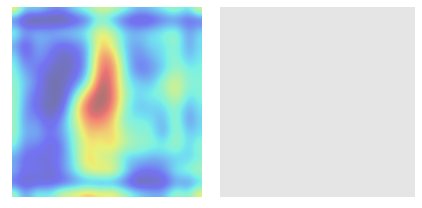

In [49]:
f, ax = plt.subplots(**subprot_args)
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    # ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

# 

Test

In [0]:
# testX = np.load("/content/drive/My Drive/Colab Notebooks/testx.npy")
# testY = np.load("/content/drive/My Drive/Colab Notebooks/testy.npy")

In [0]:
# import numpy as np
# from imblearn.metrics import classification_report_imbalanced
# from imblearn.metrics import specificity_score

# # print(classification_report_imbalanced(testY_temp, predIdxs))
# print(specificity_score(testY_temp, predIdxs, average='weighted'))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      1.00      0.97      0.97      0.93        49
          1       0.95      0.97      0.96      0.96      0.96      0.93       269
          2       0.96      0.96      0.97      0.96      0.96      0.92       269

avg / total       0.96      0.96      0.97      0.96      0.96      0.93       587

0.9654141621934365


In [0]:
# predIdxs = model.predict(testX_new, batch_size=32)
# predIdxs = np.argmax(predIdxs, axis=1)
# # predIdxs= predIdxs.tolist()
# print(classification_report(testY_temp.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

In [0]:
# !pip install keras-vis

In [0]:
# print(Y[2009])

In [0]:
# ynew = model.predict(img_test)
# print(ynew)
# print(ynew[0][0])
# print(ynew[0][1])
# print(ynew[0][2])

In [0]:
# print(images.dtype)

In [0]:

# from tensorflow.keras import backend as K
# from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# # Create Saliency object
# saliency = Saliency(model, model_modifier, clone=False)

# # Generate saliency map
# # saliency_map = saliency(loss, X_pre)
# # saliency_map = normalize(saliency_map)

# # f, ax = plt.subplots(**subprot_args)
# # for i in range(len(saliency_map)):
# #     ax[i].imshow(saliency_map[i], cmap='jet')
# # plt.tight_layout()
# # plt.show()

# saliency_map = saliency(loss, X_pre, smooth_samples=20)
# saliency_map = normalize(saliency_map)

# f, ax = plt.subplots(**subprot_args)
# for i in range(len(saliency_map)):
#     ax[i].imshow(saliency_map[i], cmap='jet')
# plt.tight_layout()
# plt.show()

In [0]:
# for ilayer, layer in enumerate(model.layers):
#     print("{:3.0f} {:10}".format(ilayer, layer.name))


In [0]:

# import tensorflow as tf
# import tensorflow.keras

# import vis ## keras-vis
# import matplotlib.pyplot as plt
# import numpy as np
# print("keras      {}".format(keras.__version__))
# print("tensorflow {}".format(tf.__version__))# import keras


In [0]:
# from scipy.fftpack import _init_nd_shape_and_axes_sorted

In [0]:
# from vis.utils import utils
# # Utility to search for layer index by name. 
# # Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'dense_1')
# # Swap softmax with linear
# model.layers[layer_idx].activation = keras.activations.linear
# model = utils.apply_modifications(model,)

In [0]:
# from vis.visualization import visualize_cam
# penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv3") 
# class_idx  = class_idxs_sorted[0]
# seed_input = img
# grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
#                            penultimate_layer_idx = penultimate_layer_idx,#None,
#                            backprop_modifier     = None,
#                            grad_modifier         = None)

In [0]:
# def plot_map(grads):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
#     axes[0].imshow(_img)
#     axes[1].imshow(_img)
#     i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
#     fig.colorbar(i)
#     plt.suptitle("Pr(class={}) = {:5.2f}".format(
#                       classlabel[class_idx],
#                       y_pred[0,class_idx]))
# plot_map(grad_top1)

In [0]:
# for class_idx in class_idxs_sorted[:topNclass]:
#     grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
#                            penultimate_layer_idx = penultimate_layer_idx,
#                            backprop_modifier     = None,
#                            grad_modifier         = None)
#     plot_map(grads)

In [0]:
# densenet = DenseNet121(
#     weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
#     include_top=False,
#     input_shape=(32,32,3)
# )


# modeld = Sequential()
# modeld.add(densenet)
# modeld.add(layers.GlobalAveragePooling2D())
# modeld.add(layers.Dense(14, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

# model.compile(
#     loss='categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# checkpoint = ModelCheckpoint(
#     'model.h5', 
#     monitor='val_acc', 
#     verbose=1, 
#     save_best_only=True, 
#     save_weights_only=False,
#     mode='auto'
# )

# history = model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=64,
#     epochs=7,
#     callbacks=[checkpoint, f1_metrics],
#     validation_split=0.1
# )